In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
import datetime
import folium

In [231]:
dfLocation = pd.read_csv('dublinbikes_20200101_20200401.csv', usecols=['STATION ID','NAME','LATITUDE','LONGITUDE'])
dfBikes = pd.read_csv('dublinbikes_20200101_20200401.csv',usecols=[0,1,3,6],  parse_dates=[1])
df = pd.read_csv('dublinbikes_20200101_20200401.csv')
dfLocation = dfLocation.drop_duplicates(subset=['STATION ID'])
print(dfBikes.columns)

Index(['STATION ID', 'TIME', 'NAME', 'AVAILABLE BIKES'], dtype='object')


In [232]:
m = folium.Map(location=[dfLocation['LATITUDE'].mean(), dfLocation['LONGITUDE'].mean()], zoom_start=13)
for lat, ln, name in zip(dfLocation['LATITUDE'], dfLocation['LONGITUDE'], dfLocation['NAME']):
    folium.Marker(location=[lat, ln],popup = name).add_to(m)
m

In [233]:
dfBikes

,STATION ID,TIME,NAME,AVAILABLE BIKES
0,2,2020-01-01 06:25:02,BLESSINGTON STREET,2
1,2,2020-01-01 06:30:02,BLESSINGTON STREET,2
2,2,2020-01-01 06:35:02,BLESSINGTON STREET,2
3,2,2020-01-01 06:40:03,BLESSINGTON STREET,0
4,2,2020-01-01 06:45:02,BLESSINGTON STREET,0
...,...,...,...,...
2228273,117,2020-04-01 23:35:02,HANOVER QUAY EAST,3
2228274,117,2020-04-01 23:40:02,HANOVER QUAY EAST,3
2228275,117,2020-04-01 23:45:02,HANOVER QUAY EAST,3
2228276,117,2020-04-01 23:50:03,HANOVER QUAY EAST,3


In [234]:
dfSDR = dfBikes[dfBikes['NAME'] == 'SOUTH DOCK ROAD']
dfSLS = dfBikes[dfBikes['NAME'] == 'LEINSTER STREET SOUTH']
dfSDR.reset_index(drop=True,inplace=True)
dfSLS.reset_index(drop=True,inplace=True)
print(dfSDR.head(), flush=True)
dfSDR.to_csv('SDR.csv')
# print(dfSLS.head(), flush= True)

   STATION ID                TIME             NAME  AVAILABLE BIKES
0          91 2020-01-01 06:25:02  SOUTH DOCK ROAD               16
1          91 2020-01-01 06:30:02  SOUTH DOCK ROAD               16
2          91 2020-01-01 06:35:02  SOUTH DOCK ROAD               16
3          91 2020-01-01 06:40:03  SOUTH DOCK ROAD               17
4          91 2020-01-01 06:45:02  SOUTH DOCK ROAD               18


Plotting Raw Data

data sampling interval is 300 secs


/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1069201242.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full_sdr=pd.array(pd.DatetimeIndex(dfSDR.iloc[:,1]).astype(np.int64))/1000000000
/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1069201242.py:6: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full_sls=pd.array(pd.DatetimeIndex(dfSLS.iloc[:,1]).astype(np.int64))/1000000000
/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1069201242.py:11: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1069201242.py:12: 

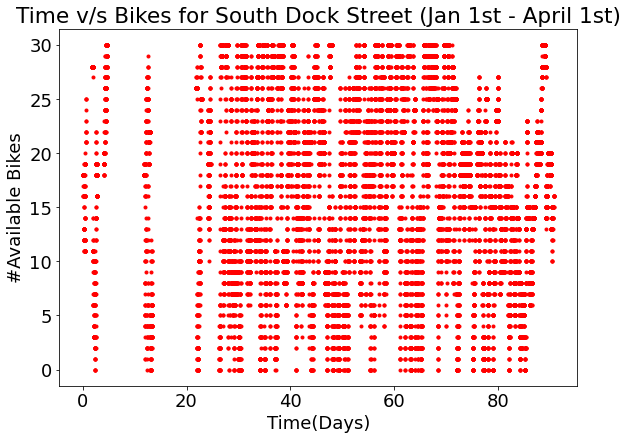

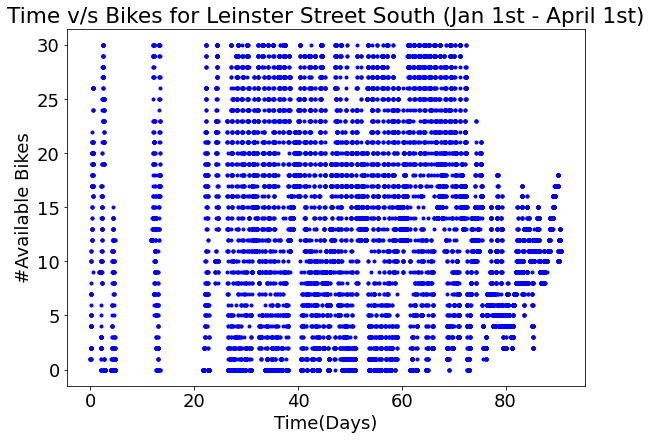

In [235]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True
start=pd.to_datetime('01−01−2020',format='%d−%m−%Y')
end=pd.to_datetime('01−04−2020',format='%d−%m−%Y')
# convert date/time to unix timestamp in sec
t_full_sdr=pd.array(pd.DatetimeIndex(dfSDR.iloc[:,1]).astype(np.int64))/1000000000
t_full_sls=pd.array(pd.DatetimeIndex(dfSLS.iloc[:,1]).astype(np.int64))/1000000000
dt_sdr = t_full_sdr[1]-t_full_sdr[0]
dt_sls = t_full_sls[1]-t_full_sls[0]
print('data sampling interval is %d secs'%dt_sls)
# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t_sdr = np.extract([(np.array(t_full_sdr)>=t_start[0]) & (np.array(t_full_sdr)<=t_end[0])], t_full_sdr)
t_sls = np.extract([(np.array(t_full_sls)>=t_start[0]) & (np.array(t_full_sls)<=t_end[0])], t_full_sdr)

t_sdr= (t_sdr  - t_sdr[0])/60/60/24 # convert timestamp to days
t_sls= (t_sls - t_sls[0])/60/60/24 # convert timestamp to days

y_sdr = np.extract([(np.array(t_full_sdr)>=t_start[0]) & (np.array(t_full_sdr)<=t_end[0])], dfSDR.iloc[:,3]).astype(np.int64)
y_sls = np.extract([(np.array(t_full_sls)>=t_start[0]) & (np.array(t_full_sls)<=t_end[0])], dfSLS.iloc[:,3]).astype(np.int64)

#plot extracted data
plt.scatter(t_sdr,y_sdr, color='red', marker='.');plt.title('Time v/s Bikes for South Dock Street (Jan 1st - April 1st)'); plt.xlabel('Time(Days)'); plt.ylabel('#Available Bikes'); plt.show()
plt.scatter(t_sls,y_sls, color='blue', marker='.'); plt.title('Time v/s Bikes for Leinster Street South (Jan 1st - April 1st)'); plt.xlabel('Time(Days)'); plt.ylabel('#Available Bikes'); plt.show()

data sampling interval is 300 secs


/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1529196017.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full_sdr=pd.array(pd.DatetimeIndex(dfSDR.iloc[:,1]).astype(np.int64))/1000000000
/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1529196017.py:6: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full_sls=pd.array(pd.DatetimeIndex(dfSLS.iloc[:,1]).astype(np.int64))/1000000000
/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1529196017.py:11: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
/var/folders/d0/_33hw0mj3r15rzs9z2jbfzhc0000gn/T/ipykernel_1073/1529196017.py:12: 

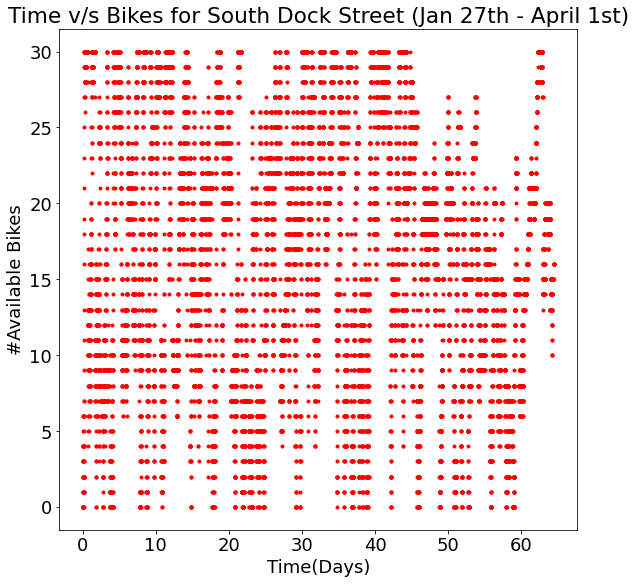

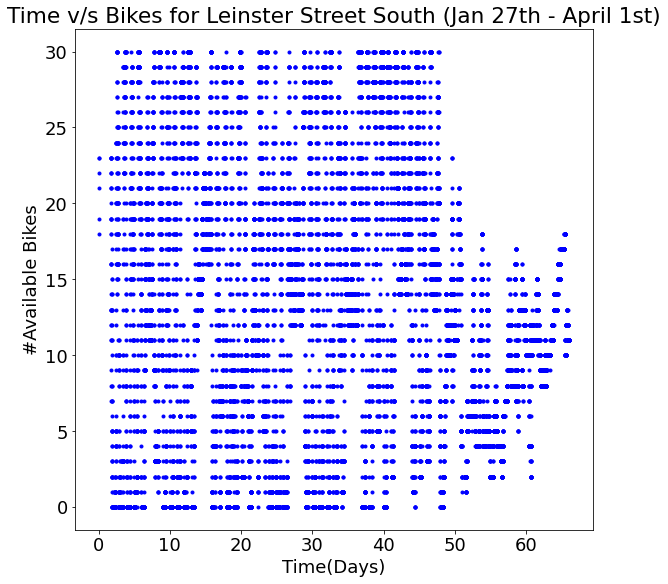

In [236]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True; plt.rcParams["figure.figsize"] = (8,8)
start=pd.to_datetime('27−01−2020',format='%d−%m−%Y')
end=pd.to_datetime('01−04−2020',format='%d−%m−%Y')
# convert date/time to unix timestamp in sec
t_full_sdr=pd.array(pd.DatetimeIndex(dfSDR.iloc[:,1]).astype(np.int64))/1000000000
t_full_sls=pd.array(pd.DatetimeIndex(dfSLS.iloc[:,1]).astype(np.int64))/1000000000
dt_sdr = t_full_sdr[1]-t_full_sdr[0]
dt_sls = t_full_sls[1]-t_full_sls[0]
print('data sampling interval is %d secs'%dt_sls)
# extract data between start and end dates
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t_sdr = np.extract([(np.array(t_full_sdr)>=t_start[0]) & (np.array(t_full_sdr)<=t_end[0])], t_full_sdr)
t_sls = np.extract([(np.array(t_full_sls)>=t_start[0]) & (np.array(t_full_sls)<=t_end[0])], t_full_sdr)

t_raw_sdr = np.extract([(np.array(t_full_sdr)>=t_start[0]) & (np.array(t_full_sdr)<=t_end[0])], dfSDR.iloc[:,1])
t_raw_sls = np.extract([(np.array(t_full_sls)>=t_start[0]) & (np.array(t_full_sls)<=t_end[0])], dfSLS.iloc[:,1])

t_sdr= (t_sdr  - t_sdr[0])/60/60/24 # convert timestamp to days
t_sls= (t_sls - t_sls[0])/60/60/24 # convert timestamp to days

y_sdr = np.extract([(np.array(t_full_sdr)>=t_start[0]) & (np.array(t_full_sdr)<=t_end[0])], dfSDR.iloc[:,3]).astype(np.int64)
y_sls = np.extract([(np.array(t_full_sls)>=t_start[0]) & (np.array(t_full_sls)<=t_end[0])], dfSLS.iloc[:,3]).astype(np.int64)

#plot extracted data
plt.scatter(t_sdr,y_sdr, color='red', marker='.'); plt.title('Time v/s Bikes for South Dock Street (Jan 27th - April 1st)'); plt.xlabel('Time(Days)'); plt.ylabel('#Available Bikes'); plt.show()
plt.scatter(t_sls,y_sls, color='blue', marker='.'); plt.title('Time v/s Bikes for Leinster Street South (Jan 27th - April 1st)'); plt.xlabel('Time(Days)'); plt.ylabel('#Available Bikes'); plt.show()

In [237]:
print(type(t_raw_sdr))
print(type(y_sdr))
print(t_raw_sdr.size)
print(y_sdr.size)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
18403
18403


In [238]:
days_range = dfSDR['TIME'].max() - dfSDR['TIME'].min()
days_range = days_range.days

base = pd.to_datetime('01−01−2020',format='%d−%m−%Y')
date_list = [base + datetime.timedelta(days=x) for x in range(days_range)]

date_list_1 = [x.date() for x in date_list]
date_available = [x.date() for x in dfSDR['TIME']]

diff = set(date_list_1) - set(date_available)
print(list(diff))

[datetime.date(2020, 1, 20), datetime.date(2020, 1, 15), datetime.date(2020, 1, 18), datetime.date(2020, 1, 22), datetime.date(2020, 1, 26), datetime.date(2020, 1, 11), datetime.date(2020, 1, 17), datetime.date(2020, 1, 7), datetime.date(2020, 1, 16), datetime.date(2020, 1, 12), datetime.date(2020, 1, 9), datetime.date(2020, 1, 21), datetime.date(2020, 1, 19), datetime.date(2020, 1, 2), datetime.date(2020, 1, 10), datetime.date(2020, 1, 8)]


Modelling (Ridge)

In [239]:
def test_preds(q,dd,lag,t, y,plot, label):
    #q−step ahead prediction
    plt.rcParams["figure.figsize"] = (8,6)
    stride=1
    XX=y[0:y.size - q -lag*dd:stride]
    for i in range(1,lag):
        X=y[i*dd:y.size - q - (lag - i)*dd:stride]
        XX=np.column_stack((XX,X))
    yy=y[lag*dd+q::stride]; tt=t[lag*dd+q::stride]
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Ridge
    model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
        y_pred = model.predict(XX)
        plt.scatter(t, y, color='black'); plt.scatter(tt, y_pred, color='blue')
        plt.xlabel('time (days)'); plt.ylabel('#bikes')
        plt.legend(['training data','predictions'],loc='upper right')
        day=math.floor(24*60*60/dt_sls) # number of samples per day
        # plt.xlim(((lag*dd+q)/day,(lag*dd+q)/day+2))
        plt.xlim(4*7+4,4*7+8)
        plt.title(label)
        plt.show()

Prediction (Ridge)

In [240]:
# prediction using short−term trend
plot=False
test_preds(q=10,dd=1,lag=3,plot=plot,t = t_sdr, y = y_sdr, label = 'Short Term for SDR')
test_preds(q=10,dd=1,lag=3,plot=plot,t = t_sls, y = y_sls, label = 'Short Term for SLS')

# prediction using daily seasonality
d=math.floor(24*60*60/dt_sdr) # number of samples per day
test_preds(q=d,dd=d,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Daily Seasonality for SDR')
test_preds(q=d,dd=d,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Daily Seasonality for SLS')

# prediction using weekly seasonality
w=math.floor(7*24*60*60/dt_sdr) # number of samples per day
test_preds(q=w,dd=w,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Weekly Seasonality for SDR')
test_preds(q=w,dd=w,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Weekly Seasonality for SLS')

0.0 [-0.03443713 -0.07954377  1.09183079]
0.0 [-0.1820228  -0.12117476  1.26337022]
0.0 [0.21162812 0.33063079 0.40421166]
0.0 [0.25496371 0.27747157 0.38302953]
0.0 [0.35915905 0.24620027 0.29296022]
0.0 [0.45422094 0.13741536 0.21128771]


Cross Validation Method

In [241]:
def cross_val(X,Y,label):
    c_values = [0.001, 0.01, 0.05, 1]
    mean_error = []; std_error = []
    kf = KFold(n_splits=5)

    for c in c_values:
        c_alpha = (1/(2*c))
        ridge_model = Ridge(fit_intercept=False, alpha = c_alpha)
        temp = []

        #fitting model based on kfold splits of 5 and calculateing mean square error
        for train, test in kf.split(X):
            ridge_model.fit(X[train], Y[train])
            ypred = ridge_model.predict(X[test])
            temp.append(mean_squared_error(Y[test], ypred))

        #getting mean and std for specific kfold splits
        mean_error.append(np.array(temp).mean())
        std_error.append(np.array(temp).std())
    plt.errorbar(c_values, mean_error, yerr=std_error, linewidth=3)
    plt.xlabel("c")
    plt.ylabel("Mean Square error")
    plt.title(label)
    plt.show()

Combining short term + Seasonality Ridge

In [256]:
def test_preds_combined_ridge(q,lag,t, t_raw, y,plot, label, drop_cols = []):
    global XX_rf, YY_rf
    stride=1
    w=math.floor(7*24*60*60/dt_sls) # number of samples per week
    t_raw = [pd.to_datetime(i).strftime('%Y-%m-%d %H:%M:%S') for i in t_raw]
    len = y.size - w - lag*w - q

    XX=y[lag*w+w:lag*w+w+len:stride]
    TT=t_raw[lag*w+w:lag*w+w+len:stride]
    for i in range(1,lag):
        X=y[lag*w+w-i:lag*w+w+len-i:stride]
        XX=np.column_stack((XX,X))
        T=t_raw[lag*w+w-i:lag*w+w+len-i:stride]
        TT=np.column_stack((TT,T))
    d=math.floor(24*60*60/dt_sls) # number of samples per day
    for i in range(1,lag+1):
        X=y[lag*w+w+q-i*d:lag*w+w+len+q-i*d:stride]
        XX=np.column_stack((XX,X))
        T=t_raw[lag*w+w+q-i*d:lag*w+w+len+q-i*d:stride]
        TT=np.column_stack((TT,T))

    #week
    for i in range(1,lag+1):
        X=y[lag*w+w+q-i*w:lag*w+w+q+len-i*w:stride]
        XX=np.column_stack((XX,X))
        T=t_raw[lag*w+w+q-i*w:lag*w+w+q+len-i*w:stride]
        TT=np.column_stack((TT,T))

    T = t_raw[lag*w+w+q:lag*w+w+q+len:stride]
    TT=np.column_stack((TT,T))
    dfTTRaw = pd.DataFrame(TT)
    dfTTRaw.to_csv(label+".csv")
    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]
    if drop_cols:
        XX= np.delete(XX,drop_cols,1)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    XX_rf = XX[train]
    YY_rf = yy[train]
    # alpha = 1/ (2*0.01)
    model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
    cross_val(XX[train],yy[train],label=label)
    print(model.intercept_, model.coef_)
    y_pred = model.predict(XX)
    mse = mean_squared_error(yy, y_pred)
    mae = mean_absolute_error(yy, y_pred)
    r2 = r2_score(yy, y_pred)
    print('MSE:',mse)
    print('MAE:',mae)
    print('R2:',r2)

    y_baseline_mean = [np.mean(yy)] * y_pred.size
    y_baseline_latest = XX[:,0]
    mse_baseline_mean = mean_squared_error(yy, y_baseline_mean)
    mae_baseline_mean = mean_absolute_error(yy, y_baseline_mean)
    mse_baseline_latest = mean_squared_error(yy, y_baseline_latest)
    mae_baseline_latest = mean_absolute_error(yy, y_baseline_latest)
    print('MSE Baseline (Mean):',mse_baseline_mean)
    print('MAE Baseline (Mean):',mae_baseline_mean)
    print('MSE Baseline (Latest):',mse_baseline_latest)
    print('MAE Baseline (Latest):',mae_baseline_latest)
    
    if plot:
        plt.scatter(t, y, color='black'); plt.scatter(tt, y_pred, color='blue')
        plt.xlabel('time (days)'); plt.ylabel('#bikes')
        plt.legend(['training data','predictions'],loc='upper right')
        plt.xlim((4*7+4,4*7+8))
        plt.title(label)
        plt.show()

Prediction for combined features (Ridge)

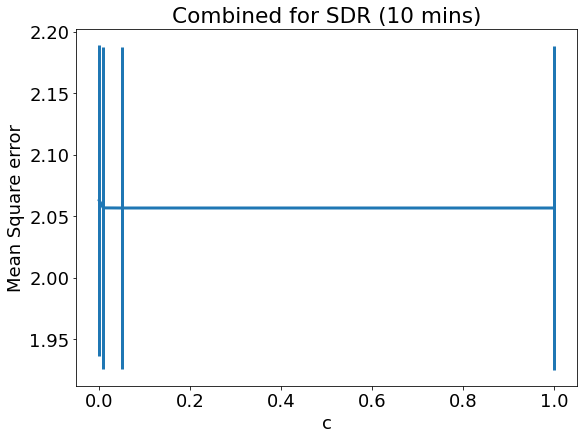

0.0 [ 1.08515884e+00 -7.62545671e-02 -3.14833924e-02  4.88763219e-03
  4.37843153e-03  4.06393601e-03  1.54656418e-03  1.07551000e-03
  6.89012144e-03]
MSE: 2.129711477276914
MAE: 0.7496630906398138
R2: 0.9679751597090764
MSE Baseline (Mean): 66.50186099071712
MAE Baseline (Mean): 6.741970930329898
MSE Baseline (Latest): 2.171036083970204
MAE Baseline (Latest): 0.6723420721679404


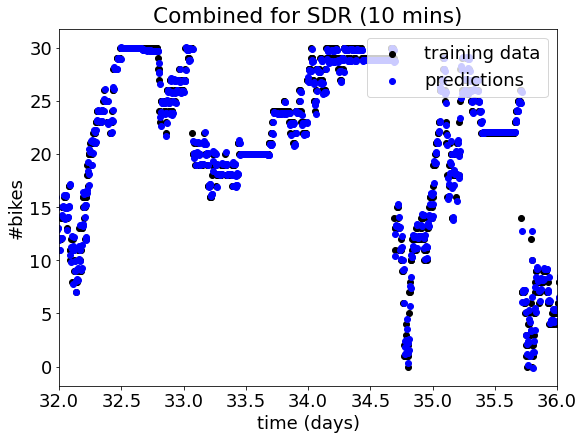

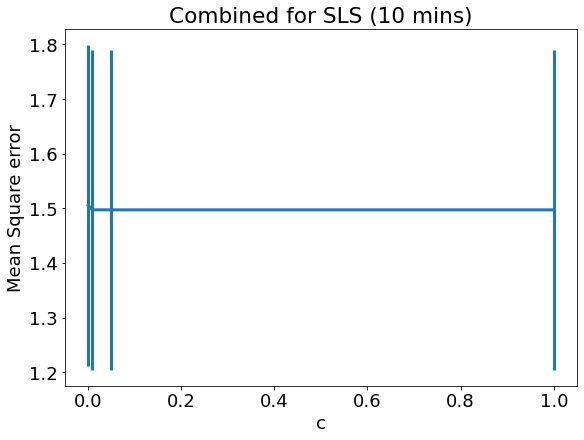

0.0 [ 1.15110336e+00 -5.92663561e-02 -1.21622110e-01  1.21744903e-02
  4.67016105e-03  2.28130100e-03  5.20186938e-03 -7.04386223e-04
  5.26810613e-03]
MSE: 1.4853416669790485
MAE: 0.5893136377035142
R2: 0.978034279114921
MSE Baseline (Mean): 67.62089324316345
MAE Baseline (Mean): 6.567556933919541
MSE Baseline (Latest): 1.540388894263326
MAE Baseline (Latest): 0.508948437651156


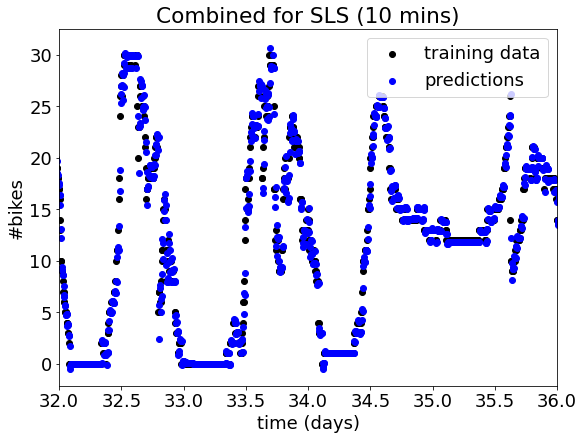

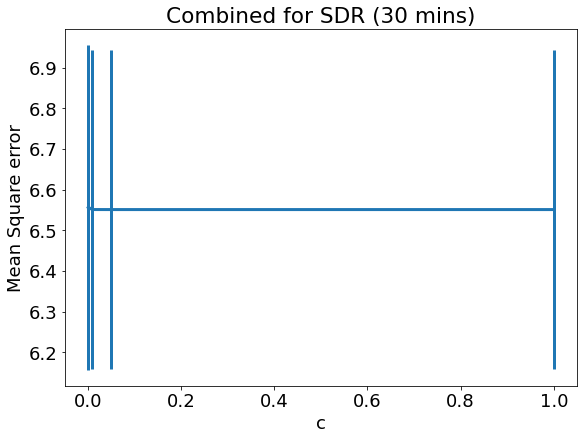

0.0 [ 1.04843014 -0.10585664 -0.01021262  0.01467175  0.01439126  0.01202252
  0.00199587  0.00608968  0.01870544]
MSE: 6.645687070370746
MAE: 1.5394925108821647
R2: 0.9001004790060587
MSE Baseline (Mean): 66.52371306939291
MAE Baseline (Mean): 6.743300133054057
MSE Baseline (Latest): 6.961095519210297
MAE Baseline (Latest): 1.417303783993032


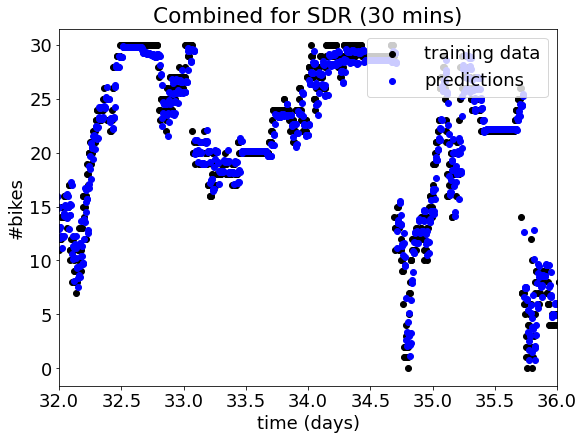

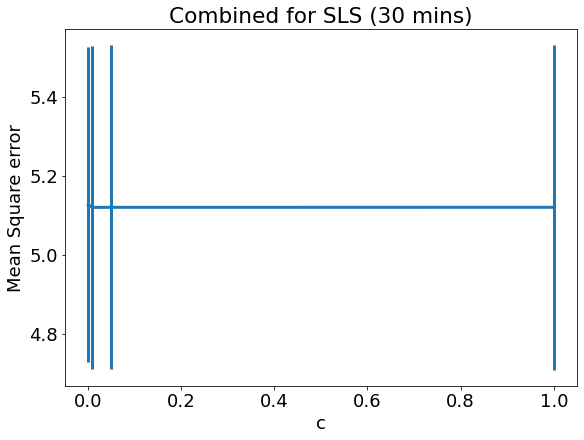

0.0 [ 1.17849631 -0.06921475 -0.22099513  0.05502011  0.01577934  0.00831385
  0.01661323  0.00757046  0.00722603]
MSE: 5.110119701150257
MAE: 1.3230590510728217
R2: 0.9243976512711024
MSE Baseline (Mean): 67.59207600116545
MAE Baseline (Mean): 6.565164030806187
MSE Baseline (Latest): 5.59856769573212
MAE Baseline (Latest): 1.165779541275525


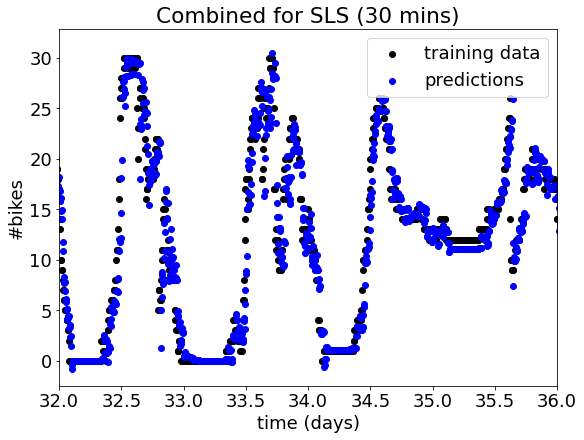

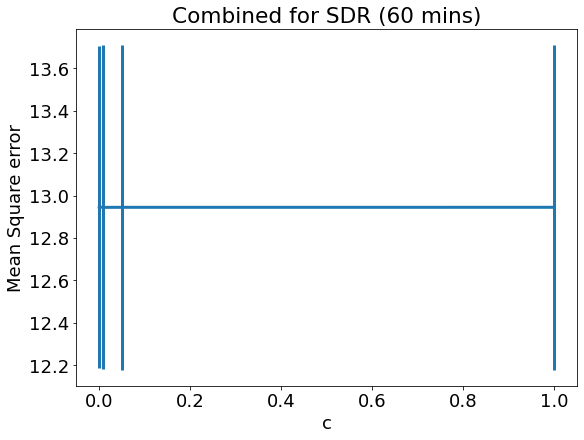

0.0 [ 0.9696211  -0.03991984 -0.06731555  0.02793677  0.02942885  0.02834111
  0.00313316  0.00879766  0.0400679 ]
MSE: 12.742837843117584
MAE: 2.3084836814572642
R2: 0.8085413452444319
MSE Baseline (Mean): 66.55660387557901
MAE Baseline (Mean): 6.745345044112804
MSE Baseline (Latest): 14.003873341725575
MAE Baseline (Latest): 2.1413769729834415


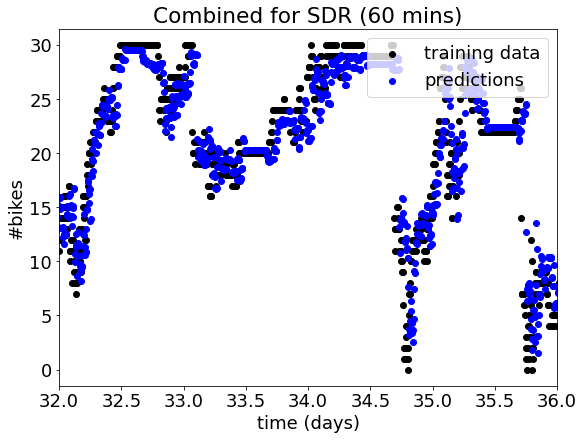

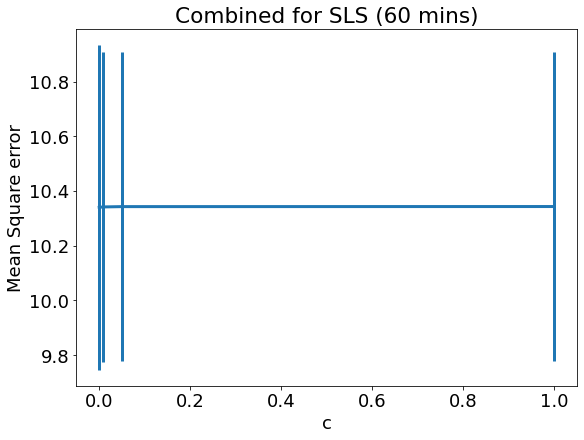

0.0 [ 1.09254568 -0.08270925 -0.24478083  0.1083419   0.03400128  0.01430144
  0.04450254  0.01173899  0.01787188]
MSE: 10.2680781257406
MAE: 2.0964143417676753
R2: 0.8480264540059739
MSE Baseline (Mean): 67.56490452716177
MAE Baseline (Mean): 6.562341968609335
MSE Baseline (Latest): 12.428294761305317
MAE Baseline (Latest): 1.8960976082114844


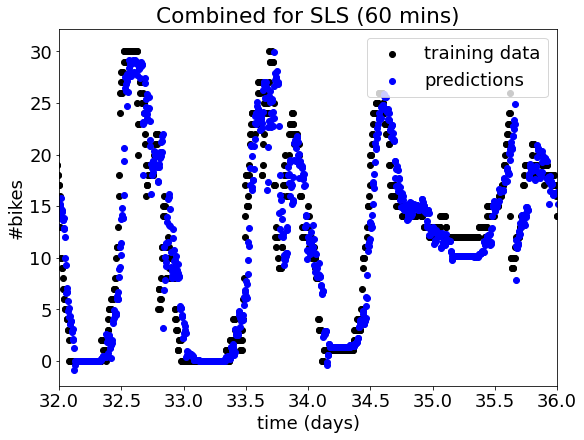

In [257]:
# prediction using short−term trend
plot=True
test_preds_combined_ridge(q=2,lag=3,plot=plot,t = t_sdr, t_raw= t_raw_sdr, y = y_sdr, label = 'Combined for SDR (10 mins)')
test_preds_combined_ridge(q=2,lag=3,plot=plot,t = t_sls, t_raw= t_raw_sls, y = y_sls, label = 'Combined for SLS (10 mins)')

test_preds_combined_ridge(q=6,lag=3,plot=plot, t = t_sdr,t_raw= t_raw_sdr, y = y_sdr, label = 'Combined for SDR (30 mins)')
test_preds_combined_ridge(q=6,lag=3,plot=plot, t = t_sls, t_raw= t_raw_sls, y = y_sls, label = 'Combined for SLS (30 mins)')

test_preds_combined_ridge(q=12,lag=3,plot=plot, t = t_sdr, t_raw= t_raw_sdr, y = y_sdr, label = 'Combined for SDR (60 mins)')
test_preds_combined_ridge(q=12,lag=3,plot=plot, t = t_sls, t_raw= t_raw_sls, y = y_sls, label = 'Combined for SLS (60 mins)')

In [ ]:
# plot=True
# test_preds_combined_ridge(q=2,lag=3,plot=plot,t = t_sdr, y = y_sdr, label = 'Combined for SDR (10 mins)', drop_cols=[0,3,4,7,8])
# test_preds_combined_ridge(q=2,lag=3,plot=plot,t = t_sls, y = y_sls, label = 'Combined for SLS (10 mins)', drop_cols=[0,1,2,3,7,8])

# test_preds_combined_ridge(q=6,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Combined for SDR (30 mins)', drop_cols=[0,3,4,5,7,8])
# test_preds_combined_ridge(q=6,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Combined for SLS (30 mins)', drop_cols=[0,1,2,3,7,8])

# test_preds_combined_ridge(q=12,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Combined for SDR (60 mins)', drop_cols=[0,3,4,5,7,8])
# test_preds_combined_ridge(q=12,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Combined for SLS (60 mins)', drop_cols=[0,1,2,3,7,8])

**Random Forest**


In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 80, stop = 400, num = 10)]
# Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(2, 50, num = 10)]
max_depth.append(None)
r_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint(r_grid)

{'max_depth': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50, None],
 'n_estimators': [80, 115, 151, 186, 222, 257, 293, 328, 364, 400]}


In [ ]:
rf = RandomForestRegressor()
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = r_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 10)
# Fit the random search model
rf_random.fit(XX_rf, YY_rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .......................max_depth=7, n_estimators=80; total time=   0.9s
[CV] END .......................max_depth=7, n_estimators=80; total time=   0.9s
[CV] END .......................max_depth=7, n_estimators=80; total time=   1.0s
[CV] END .......................max_depth=7, n_estimators=80; total time=   1.0s
[CV] END .......................max_depth=7, n_estimators=80; total time=   1.0s
[CV] END ......................max_depth=2, n_estimators=222; total time=   1.0s
[CV] END ......................max_depth=2, n_estimators=222; total time=   1.0s
[CV] END ......................max_depth=2, n_estimators=222; total time=   1.0s
[CV] END ......................max_depth=2, n_estimators=222; total time=   1.1s
[CV] END ......................max_depth=2, n_estimators=222; total time=   1.1s
[CV] END .....................max_depth=44, n_estimators=222; total time=   5.2s
[CV] END .....................max_depth=44, n_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=10,
                   param_distributions={'max_depth': [2, 7, 12, 18, 23, 28, 34,
                                                      39, 44, 50, None],
                                        'n_estimators': [80, 115, 151, 186, 222,
                                                         257, 293, 328, 364,
                                                         400]},
                   random_state=42, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 364, 'max_depth': 28}

In [258]:
def test_preds_combined_random_forest(q,lag,t, y,plot, label, drop_cols = []):
# q=10
# lag=3; 
    global XX_rf, YY_rf
    stride=1
    w=math.floor(7*24*60*60/dt_sls) # number of samples per week
    len = y.size - w - lag*w - q

    XX=y[lag*w+w:lag*w+w+len:stride]
    for i in range(1,lag):
        X=y[lag*w+w-i:lag*w+w+len-i:stride]
        XX=np.column_stack((XX,X))
        
    d=math.floor(24*60*60/dt_sls) # number of samples per day
    for i in range(1,lag+1):
        X=y[lag*w+w+q-i*d:lag*w+w+len+q-i*d:stride]
        XX=np.column_stack((XX,X))

    #week
    for i in range(1,lag+1):
        X=y[lag*w+w+q-i*w:lag*w+w+q+len-i*w:stride]
        XX=np.column_stack((XX,X))


    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]
    if drop_cols:
        XX= np.delete(XX,drop_cols,1)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    XX_rf = XX[train]
    YY_rf = yy[train]
    model  = RandomForestRegressor(n_estimators = 364, max_depth = 28).fit(XX[train], yy[train])
    print(model.feature_importances_)
    y_pred = model.predict(XX)
    mse = mean_squared_error(yy, y_pred)
    mae = mean_absolute_error(yy, y_pred)
    print('MSE:',mse)
    print('MAE:',mae)

    y_baseline_mean = [np.mean(yy)] * y_pred.size
    y_baseline_latest = XX[:,0]
    mse_baseline_mean = mean_squared_error(yy, y_baseline_mean)
    mae_baseline_mean = mean_absolute_error(yy, y_baseline_mean)
    mse_baseline_latest = mean_squared_error(yy, y_baseline_latest)
    mae_baseline_latest = mean_absolute_error(yy, y_baseline_latest)
    print('MSE Baseline (Mean):',mse_baseline_mean)
    print('MAE Baseline (Mean):',mae_baseline_mean)
    print('MSE Baseline (Latest):',mse_baseline_latest)
    print('MAE Baseline (Latest):',mae_baseline_latest)

    
    if plot:
        plt.scatter(t, y, color='black'); plt.scatter(tt, y_pred, color='blue')
        plt.xlabel('time (days)'); plt.ylabel('#bikes')
        plt.legend(['training data','predictions'],loc='upper right')
        plt.xlim((4*7+4,4*7+8))
        plt.title(label)
        plt.show()

[0.96830562 0.00252373 0.00268093 0.00473212 0.00433895 0.00449003
 0.00437251 0.00441705 0.00413907]
MSE: 0.6016740566470024
MAE: 0.3490470420414943
MSE Baseline (Mean): 66.50186099071712
MAE Baseline (Mean): 6.741970930329898
MSE Baseline (Latest): 2.171036083970204
MAE Baseline (Latest): 0.6723420721679404


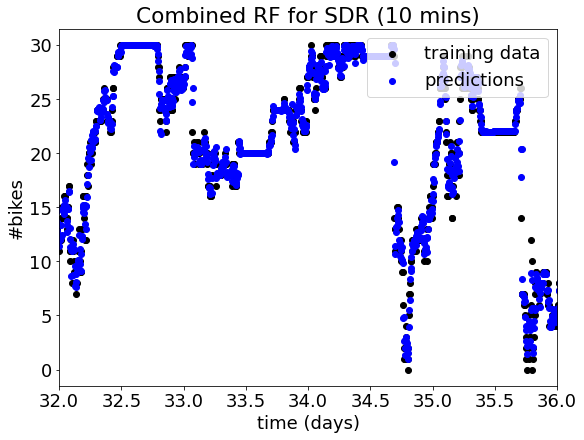

[0.97906674 0.00153399 0.00246953 0.00292162 0.00309411 0.00284393
 0.00297506 0.00246805 0.00262698]
MSE: 0.44808832787469705
MAE: 0.2694230669269105
MSE Baseline (Mean): 67.62089324316345
MAE Baseline (Mean): 6.567556933919541
MSE Baseline (Latest): 1.540388894263326
MAE Baseline (Latest): 0.508948437651156


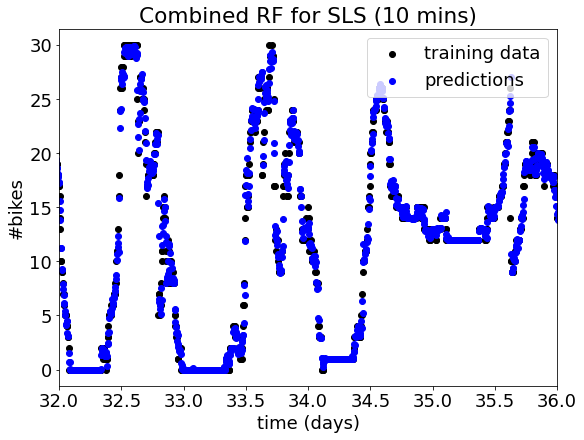

[0.90081895 0.00568626 0.00696702 0.01202526 0.01344761 0.01387392
 0.01667855 0.01646215 0.01404026]
MSE: 1.0083267818100925
MAE: 0.4717916994293886
MSE Baseline (Mean): 66.52371306939291
MAE Baseline (Mean): 6.743300133054057
MSE Baseline (Latest): 6.961095519210297
MAE Baseline (Latest): 1.417303783993032


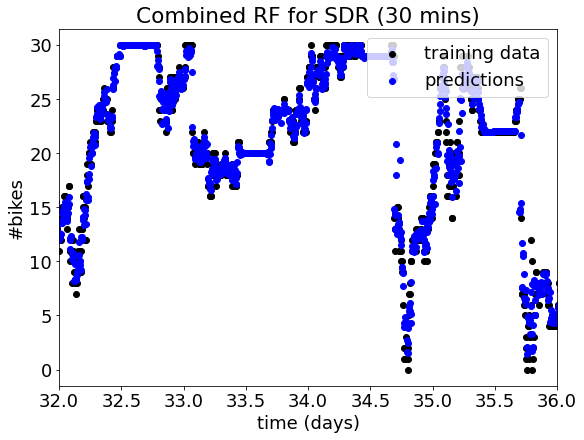

[0.92106842 0.00361451 0.00642379 0.01461173 0.01022057 0.00980291
 0.01262185 0.01102115 0.01061507]
MSE: 0.8464003732006647
MAE: 0.3755015990412055
MSE Baseline (Mean): 67.59207600116545
MAE Baseline (Mean): 6.565164030806187
MSE Baseline (Latest): 5.59856769573212
MAE Baseline (Latest): 1.165779541275525


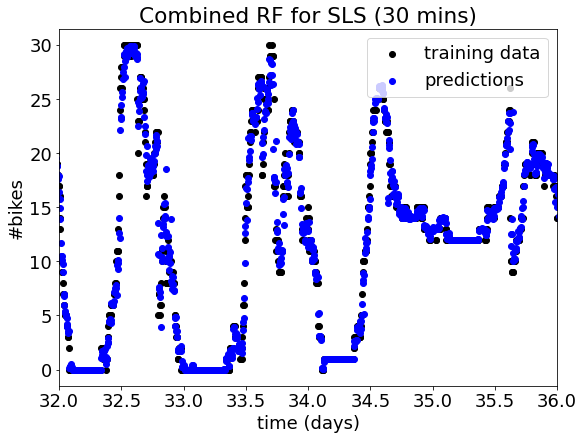

[0.80700326 0.01089013 0.01002129 0.02624831 0.02531639 0.02763967
 0.03269263 0.03268962 0.02749869]
MSE: 1.1690598623878035
MAE: 0.5081279392965539
MSE Baseline (Mean): 66.55660387557901
MAE Baseline (Mean): 6.745345044112804
MSE Baseline (Latest): 14.003873341725575
MAE Baseline (Latest): 2.1413769729834415


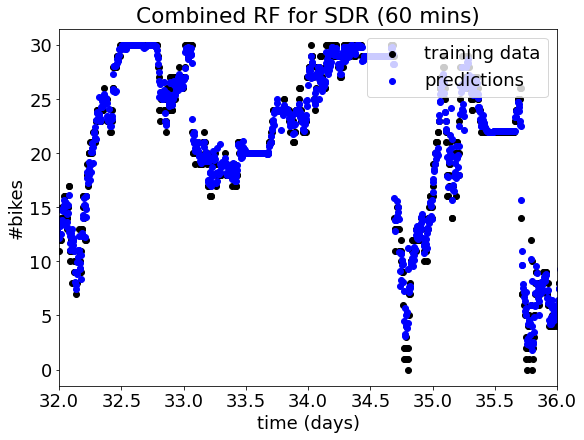

[0.82145156 0.0072555  0.00918825 0.03990769 0.03059259 0.01950569
 0.02857221 0.02285797 0.02066853]
MSE: 0.8499903549778589
MAE: 0.3883512429362617
MSE Baseline (Mean): 67.56490452716177
MAE Baseline (Mean): 6.562341968609335
MSE Baseline (Latest): 12.428294761305317
MAE Baseline (Latest): 1.8960976082114844


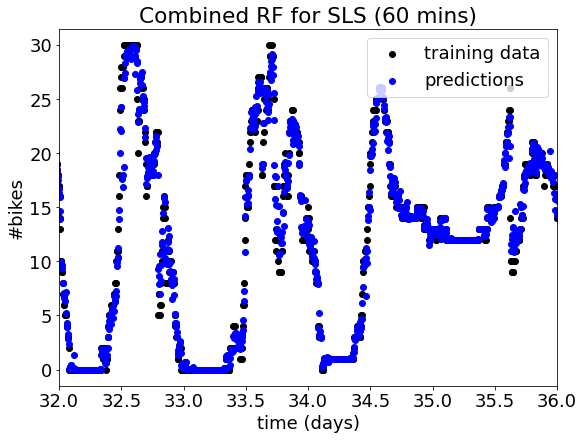

In [259]:
plot=True
# test_preds_combined_random_forest(q=2,lag=3,plot=plot,t = t_sdr, y = y_sdr, label = 'Combined RF for SDR (10 mins)', drop_cols=[0,3,4,7,8])
# test_preds_combined_random_forest(q=2,lag=3,plot=plot,t = t_sls, y = y_sls, label = 'Combined RF for SLS (10 mins)', drop_cols=[0,1,2,3,7,8])

# test_preds_combined_random_forest(q=6,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Combined RF for SDR (30 mins)', drop_cols=[0,3,4,5,7,8])
# test_preds_combined_random_forest(q=6,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Combined RF for SLS (30 mins)', drop_cols=[0,1,2,3,7,8])

# test_preds_combined_random_forest(q=12,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Combined RF for SDR (60 mins)', drop_cols=[0,3,4,5,7,8])
# test_preds_combined_random_forest(q=12,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Combined RF for SLS (60 mins)', drop_cols=[0,1,2,3,7,8])

test_preds_combined_random_forest(q=2,lag=3,plot=plot,t = t_sdr, y = y_sdr, label = 'Combined RF for SDR (10 mins)')
test_preds_combined_random_forest(q=2,lag=3,plot=plot,t = t_sls, y = y_sls, label = 'Combined RF for SLS (10 mins)')

test_preds_combined_random_forest(q=6,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Combined RF for SDR (30 mins)')
test_preds_combined_random_forest(q=6,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Combined RF for SLS (30 mins)')

test_preds_combined_random_forest(q=12,lag=3,plot=plot, t = t_sdr, y = y_sdr, label = 'Combined RF for SDR (60 mins)')
test_preds_combined_random_forest(q=12,lag=3,plot=plot, t = t_sls, y = y_sls, label = 'Combined RF for SLS (60 mins)')
